In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Fun with statistics

This notebook is a small and hand-waivy exercise to build some intuition for the kinds of distributions we encounter in RNA-seq land.

## Sum vs Product of many random numbers

First, we want to remind ourselves where the ubiquitous normal distribution comes from. It is an "attractor" in the space of probability distributions to which sums of random variables converge ([see Central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem)).
However, in biology, oftentimes random (unknown) numbers are not added, but multiplied! Think of the "rates" with which different enzymes act, or transcription factors associate with DNA etc. What happens then? Hint: $\log(a b) = \log(a) + \log(b)$

In [45]:
N = 1000000
rnd = np.random.randint(1, 1000, size=N)
x = np.arange(1, 15000, 0.01)


In [46]:
from scipy.stats import norm

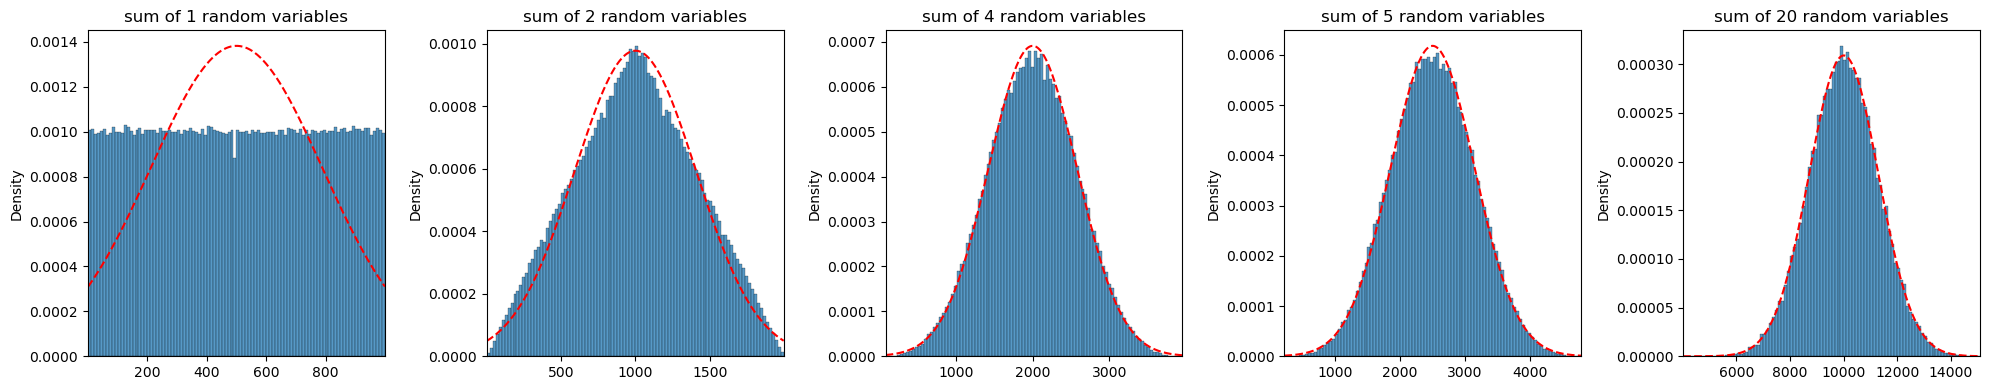

In [49]:
n_bins = 100
n_sub = [1, 2, 4, 5, 20]
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for n, ax in zip(n_sub, np.array(axes.ravel())):
    d = rnd.reshape(n,int(N/n)).sum(axis=0)
    sns.histplot(d, ax=ax, bins=n_bins, stat='density')
    ax.plot(x, norm.pdf(x, n*rnd.mean(), rnd.std()*np.sqrt(n)), 'r--')
    ax.title.set_text(f"sum of {n} random variables")
    ax.set_xlim(d.min(), d.max())

plt.tight_layout()

In [34]:
rnd = np.array(rnd, dtype=np.float64)

In [38]:
lx = np.arange(0, 140, 0.01)
lrnd = np.log10(rnd)

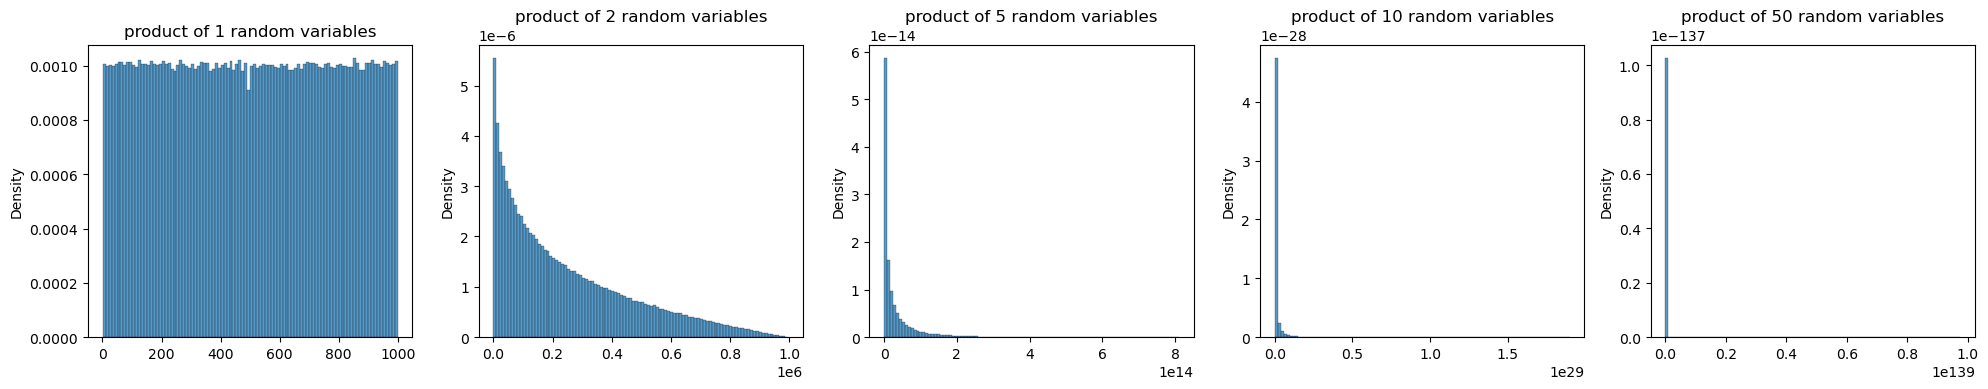

In [42]:
n_bins = 100
n_sub = [1, 2, 5, 10, 50]
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for n, ax in zip(n_sub, np.array(axes.ravel())):
    d = rnd.reshape(n,int(N/n)).prod(axis=0)
    sns.histplot(d, ax=ax, bins=n_bins, stat='density')
    #ax.plot(x, norm.pdf(x, rnd.mean(), rnd.std()/np.sqrt(n)), 'r--')
    ax.title.set_text(f"product of {n} random variables")

plt.tight_layout()

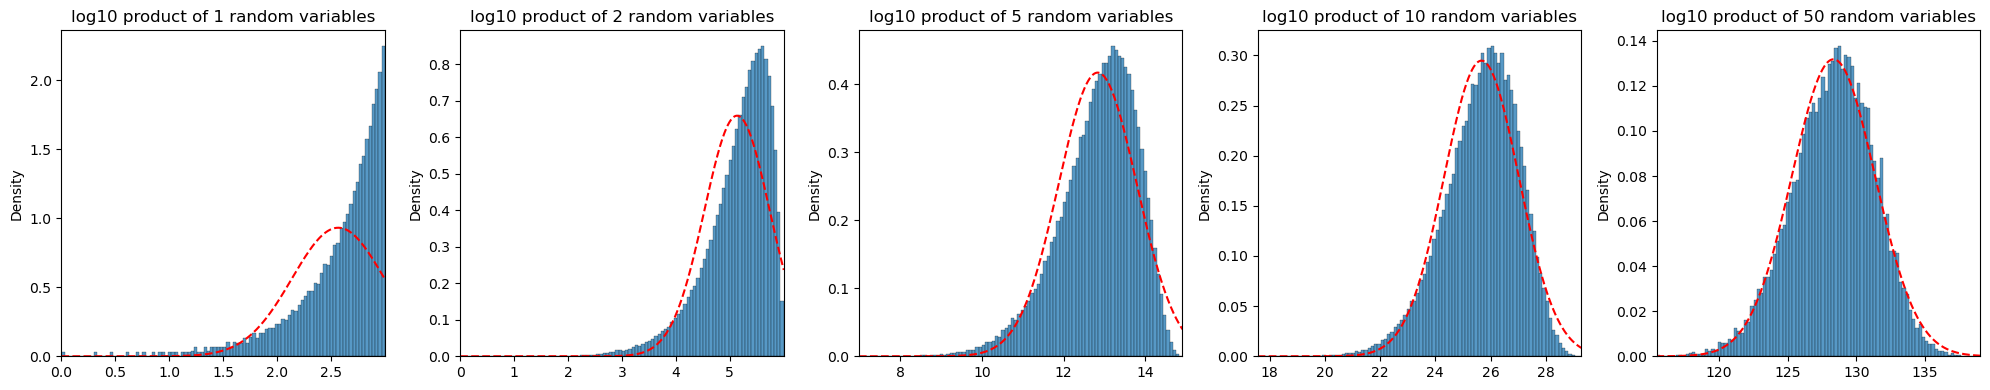

In [43]:
n_bins = 100
n_sub = [1, 2, 5, 10, 50]
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for n, ax in zip(n_sub, np.array(axes.ravel())):
    d = np.log10(rnd.reshape(n, int(N/n)).prod(axis=0))
    sns.histplot(d, ax=ax, bins=n_bins, stat='density')
    ax.plot(lx, norm.pdf(lx, n*lrnd.mean(), lrnd.std()*np.sqrt(n)), 'r--')    
    ax.title.set_text(f"log10 product of {n} random variables")
    ax.set_xlim(d.min(), d.max())

plt.tight_layout()

## ubiquity of log-normal distribution in biology

Now we have some intuition for the log-normal distribution of so many variables in biology: a log-normally distributed value (such as mRNA expression level) can be interpreted as the product of many unknown (random) variables. Other examples are transcript size, half-life time of RNAs and proteins.

## Sampling statistics

Overall, gene expression will look approximately log-normal (sometimes with a second peak, what could that be?). But most genes are not very highly expressed. Therefore the "statistics of small numbers" or sampling statistics becomes very important. Let's look at counts of a low-probability event first. We are interested in detecting a fragment of cDNA from a particular gene's mRNA. We know that there are many other mRNAs floating around, so the chance to detect this one particular gene is low if we randomly grab only one fragment. Can you come up with a very rough ballpark estimate?
Luckily, RNA-seq means that we have many many more tries to detect a gene. Each read is a try. The statistics of the number of successes, for a number of trials $n$ with a known probability $p$ is the binomial distribution. For small $p$ and large $n$, the binomial distribution converges to the Poisson distribution with rate $\lambda=p \cdot n$

In [89]:
N_genes = 20000
p = 1/N_genes

In [90]:
from scipy.stats import binom, poisson, nbinom

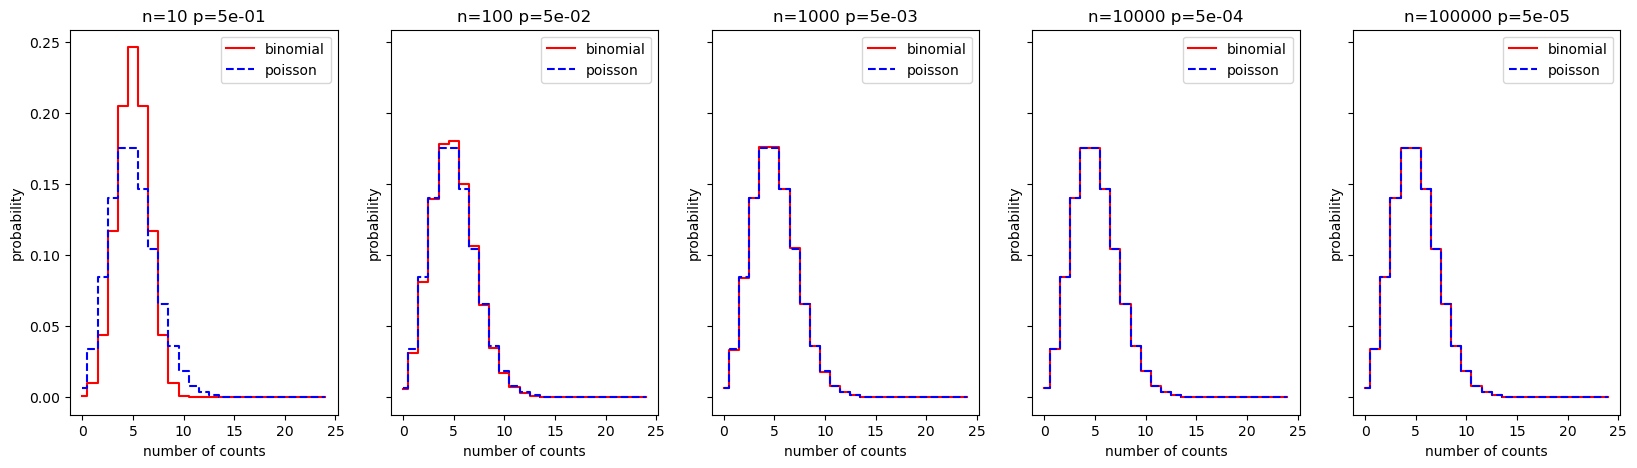

In [92]:
fig, axes = plt.subplots(1, 5, figsize=(20,5), sharex=True, sharey=True)

x = np.arange(25)
params = [
    (10, 0.5),
    (100, 0.05),
    (1000, 0.005),
    (10000, 0.0005),
    (100000, 0.00005),
]

for (n,p), ax in zip(params, np.array(axes).ravel()):
    ax.title.set_text(f"n={n} p={p:1.0e}")
    bv = binom(n=n, p=p)
    ax.step(x, bv.pmf(x), color='r', where='mid', label='binomial') 
    pv = poisson(p*n)
    ax.step(x, pv.pmf(x), color='b', where='mid', ls='dashed', label='poisson')
    ax.legend()
    ax.set_ylabel("probability")
    ax.set_xlabel("number of counts")
    

The Poisson distribution is analytically and numerically very nice! So read counts are usually considered poisson-distributed to a reasonable degree of approximation. There is only one problem: Poisson has only one parameter $\lambda$ which determines both the mean and the variance. In biology, the variance is often larger than the mean, especially for things like counts of lowly expressed genes. What could be a a reason for that? (hint: gene activity is regulated). For practical reasons, RNA-seq counts are therefore modeled as `negative binomial`. That distribution is very similar to poisson, but with an additional parameter that allows for **over-dispersion**.

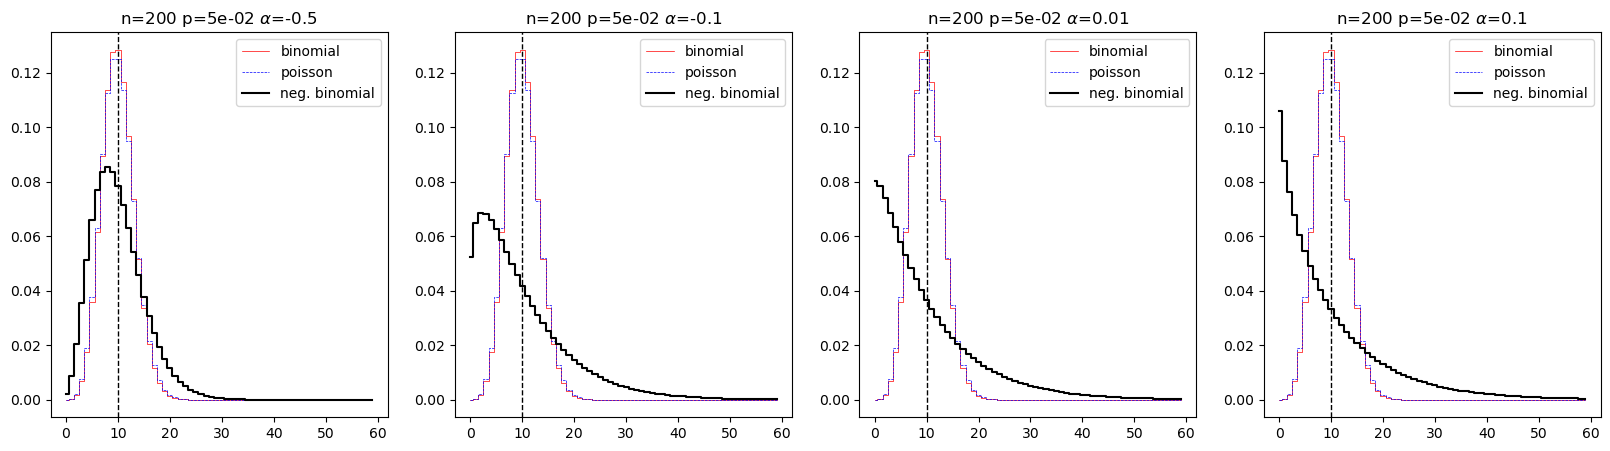

In [117]:
fig, axes = plt.subplots(1, 4, figsize=(20,5))


x = np.arange(60)
params = [
    (200, 0.05, -0.5),
    (200, 0.05, -0.1),
    (200, 0.05, 0.01),
    (200, 0.05, 0.1),
]
for (n,p, ovd), ax in zip(params, np.array(axes).ravel()):
    ax.title.set_text(f"n={n} p={p:1.0e} $\\alpha$={ovd}")
    bv = binom(n=n, p=p)
    ax.step(x, bv.pmf(x), color='r', where='mid', label='binomial', lw=0.5) 
    pv = poisson(p*n)
    ax.step(x, pv.pmf(x), color='b', where='mid', ls='dashed', label='poisson', lw=0.5)

    mu = p*n
    sigma = mu * (1 + ovd)
    nv = nbinom(mu**2/(sigma**2 - mu), mu/sigma**2)

    ax.step(x, nv.pmf(x), color='k', where='mid', label='neg. binomial')
    ax.axvline(nv.mean(), ls='dashed', lw=1, color='k')
    ax.legend()